In [31]:
from collections import Counter, defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [32]:
project_path = Path("/projects/b1171/ylk4626/project/Chimera")

In [34]:
def read_sv_annotation(file):
    """Read the SV annotation file and return a dictionary with the SVs as keys and the annotations as values."""
    result = defaultdict(list)
    with Path.open(file) as f:
        lines = f.readlines()

        for line in lines[1:]:
            dvcf, sv, sp, *lefts = line.split()
            result[int(sp)].append([sv, lefts[-1]])
    return result


def collect_inv_length(file):
    """Read the inversion annotation file and return a dictionary with the inversions as keys and the annotations as values."""
    result = []
    with Path.open(file) as f:
        lines = f.readlines()
        for line in lines[1:]:
            dvcf, inv, sp, *lefts = line.split()
            content = inv.split(":")
            if content[0] == "INV":
                chrom = content[1]
                if chrom.startswith("chr"):
                    bp1, bp2 = content[2].split("-")
                    length = int(bp2) - int(bp1)
                    result.append(abs(length))
    return result

# Determine the threshold for diff of inv bounary 

In [4]:
inv_length = collect_inv_length(
    project_path / "data/sv/PC3_10_cells_MDA_P2_dirty/chimeric_reads_mapping/updated_SVCF/cutesv.annotated_sv_1000.tsv"
)

In [5]:
len(inv_length)

525064

In [6]:
inv_length[:10]

[402, 981, 621, 188, 182, 576, 395, 117, 541, 435]

In [7]:
def draw_inv_length(data):
    """Draw a histogram of the inversion lengths."""
    # draw two figures one is histogram, the other is boxplot

    figs, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs = axs.flatten()

    sns.histplot(data, bins=100, log_scale=True, ax=axs[0])
    plt.xlabel("Inversion Length")
    plt.ylabel("Count")
    plt.title("Inversion Length Distribution")

    # get mean and median, and quantiles
    mean = sum(data) / len(data)
    median = sorted(data)[len(data) // 2]
    q1 = sorted(data)[len(data) // 4]
    q3 = sorted(data)[3 * len(data) // 4]
    axs[0].axvline(mean, color="red", linestyle="--", label=f"Mean: {mean:.2f}")
    axs[0].axvline(median, color="green", linestyle="--", label=f"Median: {median:.2f}")
    axs[0].axvline(q1, color="blue", linestyle="--", label=f"Q1: {q1:.2f}")
    axs[0].axvline(q3, color="purple", linestyle="--", label=f"Q3: {q3:.2f}")

    suggestions = {
        "strict": int(min(100, median * 0.05)),  # 5% of the median
        "moderate": int(min(500, median * 0.1)),  # 10% of the median
        "relaxed": int(min(1000, median * 0.15)),  # 20% of the median
    }
    print(suggestions)

    # calculate 95% confidence interval of the inversion length
    lower = sorted(data)[int(len(data) * 0.025)]
    upper = sorted(data)[int(len(data) * 0.975)]
    axs[0].axvline(lower, color="orange", linestyle="--", label=f"Lower: {lower:.2f}")
    axs[0].axvline(upper, color="orange", linestyle="--", label=f"Upper: {upper:.2f}")
    axs[0].legend()

    sns.boxplot(data, ax=axs[1], log_scale=True)
    plt.xlabel("Inversion Length")
    plt.title("Inversion Length Distribution")

    # I want to determine a threshold to calculate the overlapping between two inversions (one inversion is a interval [start, end])
    # show me some suggestinos how to determine the threshold

    plt.show()

{'strict': 22, 'moderate': 45, 'relaxed': 67}


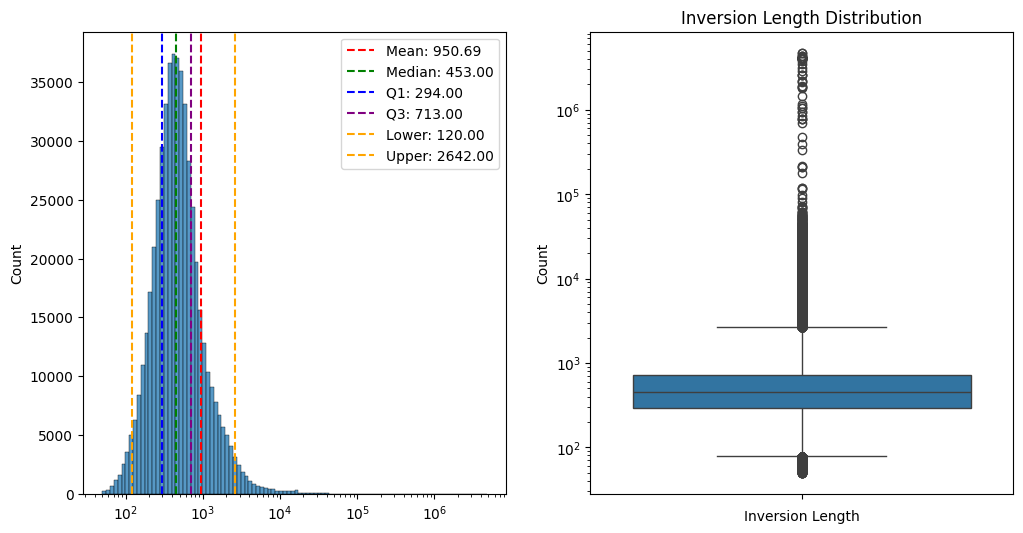

In [8]:
draw_inv_length(inv_length)


**Mathematical Justification:**

1. **MAD-based Thresholds**:
   - Uses Median Absolute Deviation: `MAD = median(|Xi - median(X)|)`
   - For normal distributions: `σ ≈ 1.4826 * MAD`
   - Thresholds based on standard normal quantiles:
     - Strict: `0.6745 * MAD` (50% confidence)
     - Moderate: `1.4826 * MAD` (68% confidence)
     - Relaxed: `2.9652 * MAD` (95% confidence)

2. **Standard Deviation Based**:
   - Uses classical standard deviation
   - Based on normal distribution properties:
     - Strict: `0.67σ` (~50% of data)
     - Moderate: `1σ` (~68% of data)
     - Relaxed: `2σ` (~95% of data)

3. **Percentile Based**:
   - Non-parametric approach
   - Uses actual data distribution
   - Takes 5% of different quartiles

**Why These Methods?**

1. **MAD-based** is robust to outliers and preferred when:
   - Data has outliers
   - Distribution is heavy-tailed
   - Need stable thresholds

2. **STD-based** is traditional and good when:
   - Data is approximately normal
   - Want to use well-understood statistical properties
   - Have clean data without major outliers

3. **Percentile-based** is distribution-agnostic and preferred when:
   - Data is not normally distributed
   - Want to avoid assumptions about distribution
   - Need robust thresholds based on actual data shape

The choice between these methods depends on:
1. Your data distribution (check Q-Q plot)
2. Presence of outliers
3. Required statistical confidence
4. Biological meaning of the thresholds

I recommend:
1. Check the Q-Q plot to understand your data distribution
2. If approximately normal: use STD-based
3. If heavy-tailed or with outliers: use MAD-based
4. If neither fits well: use percentile-based

This approach provides statistically justified thresholds with clear confidence levels and assumptions.


In [9]:
def calculate_statistical_thresholds(inv_lengths):
    """Calculate thresholds based on statistical properties of the data.

    Args:
        inv_lengths (list): List of inversion lengths

    Returns:
        dict: Different thresholds with statistical justification
    """
    # Convert to numpy array for calculations
    lengths = np.array(inv_lengths)

    # Basic statistics
    median = np.median(lengths)
    mad = np.median(np.abs(lengths - median))  # Median Absolute Deviation
    std = np.std(lengths)

    # Calculate thresholds based on different statistical principles
    return {
        # Based on MAD (robust to outliers)
        "mad_based": {
            "strict": int(0.6745 * mad),  # ~50% confidence interval for normal distribution
            "moderate": int(1.4826 * mad),  # ~68% confidence interval (1 sigma equivalent)
            "relaxed": int(2.9652 * mad),  # ~95% confidence interval (2 sigma equivalent)
        },
        # Based on standard deviation
        "std_based": {
            "strict": int(std * 0.67),  # ~50% confidence interval
            "moderate": int(std),  # ~68% confidence interval
            "relaxed": int(std * 2),  # ~95% confidence interval
        },
        # Based on percentiles (non-parametric)
        "percentile_based": {
            "strict": int(np.percentile(lengths, 25) * 0.05),  # 5% of Q1
            "moderate": int(np.percentile(lengths, 50) * 0.05),  # 5% of median
            "relaxed": int(np.percentile(lengths, 75) * 0.05),  # 5% of Q3
        },
    }



def analyze_threshold_distribution(inv_lengths):
    """Analyze and visualize threshold distribution.

    Args:
        inv_lengths (list): List of inversion lengths
    """
    thresholds = calculate_statistical_thresholds(inv_lengths)

    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Length distribution with thresholds
    sns.histplot(inv_lengths, bins=100, log_scale=True, ax=axes[0])

    # Add threshold lines for each method
    colors = {"mad_based": "red", "std_based": "blue", "percentile_based": "green"}
    styles = {"strict": ":", "moderate": "--", "relaxed": "-"}

    for method, color in colors.items():
        for level, style in styles.items():
            threshold = thresholds[method][level]
            axes[0].axvline(threshold, color=color, linestyle=style, label=f"{method}-{level}: {threshold}")

    axes[0].set_title("Inversion Length Distribution with Statistical Thresholds")
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Plot 2: QQ plot to check normality
    from scipy import stats

    stats.probplot(np.log10(inv_lengths), dist="norm", plot=axes[1])
    axes[1].set_title("Q-Q Plot of Log10 Inversion Lengths")

    plt.tight_layout()
    plt.show()

    return thresholds

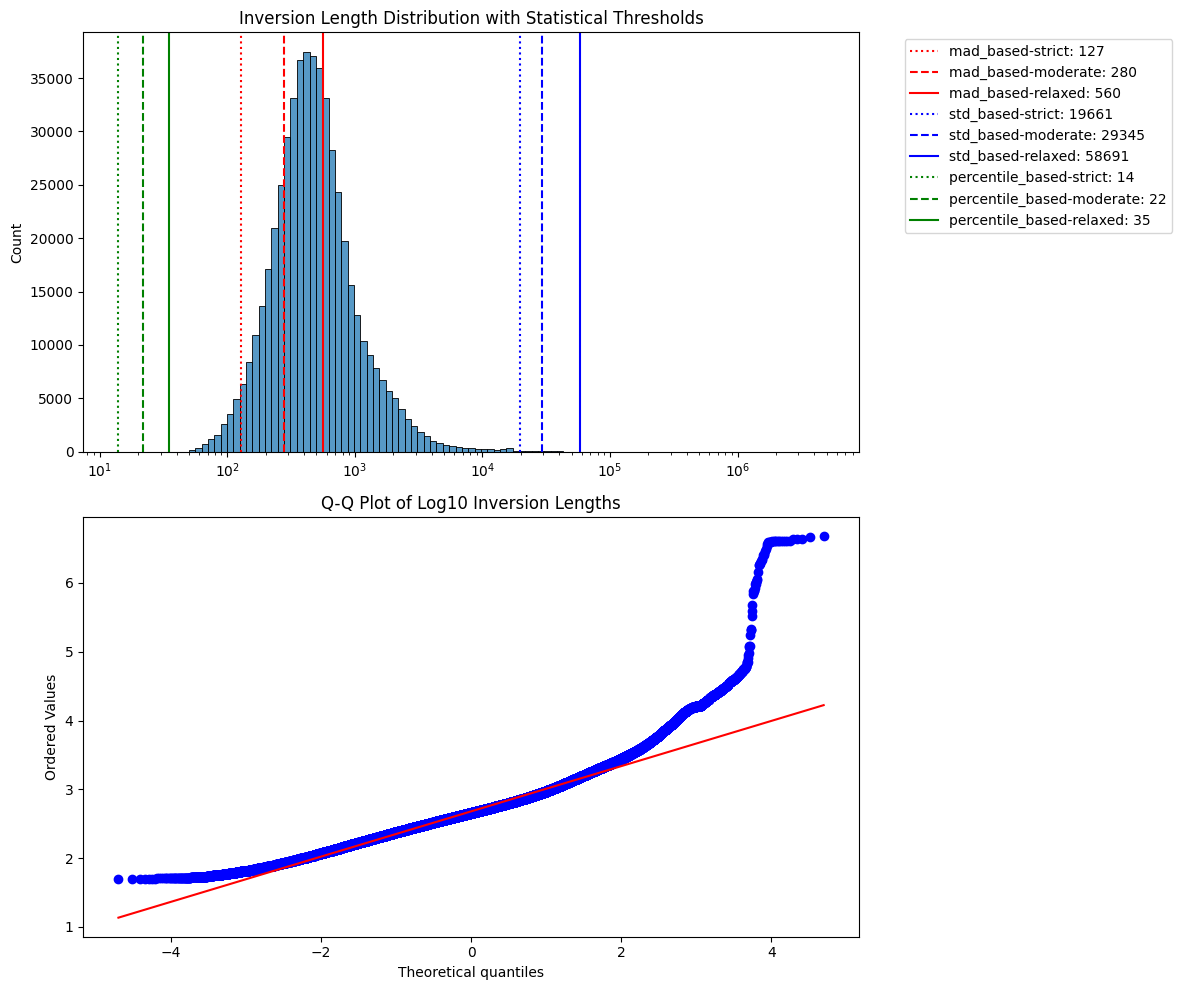

In [10]:
# Analyze the data
thresholds = analyze_threshold_distribution(inv_length)

**The distribution of inversion lengths does not follow a normal distribution but exhibits a heavy tail. Therefore, we decided to use the MAD-based threshold approach. Additionally, considering that clean data typically contains only hundreds of inversions in total, we selected a strict threshold of 127.**

# Collect read names of inversions from the training data

In [35]:
t127_result = read_sv_annotation(project_path/"data/sv/PC3_10_cells_MDA_P2_dirty/chimeric_reads_mapping/updated_SVCF/cutesv.annotated_sv_127.tsv")

In [36]:
t127_result.keys()

dict_keys([0, 2, 1, 3])

In [37]:
t127_result

defaultdict(list,
            {0: [['TRA:chr1:40364172-32435379',
               '4b9cabc9-0ada-407f-81c7-dc3cf4ec2833,59832234-81f4-447e-9493-04336f7f6787,936da1a9-8ac1-4fdb-aaa8-a4c5c79a46cf,2cbcf005-6032-4819-b0d2-bea28af9553c,fc894e44-4a29-4f3d-9c39-d93eae8eb86f,43be2ad0-f528-45ba-ad33-48c3fd28fc6d,c4d796ab-c561-40f9-bb85-c5c5269058c5,d0b778c7-820b-42c3-8021-e20838060417,463aab56-3c44-49b8-b65f-8e754023ed6c,b2a7dfb1-fc61-4d3a-b3f3-af5d07b6a3e1,36453a98-a778-4507-8cfa-208af2d10470,9e7b0344-61e5-4ae1-b495-994b2f29e2d8,3a9ef674-248a-4201-b056-1415978aee9e,1c8db978-dacc-4cbd-bb97-25a4dea4231b,f6f14a18-1959-43c1-96b4-ea60170aa502,b5abdc2c-747a-4fdc-b2f7-d61887034e00,17c4f7d8-1004-4cb8-be29-fe226e36afa5,3b06c566-86c2-4e59-9995-e2f6f5c3d1c3,a4de4288-596e-4fe9-9891-607f22a0a7f1'],
              ['TRA:chr1:40364173-32435380',
               'd6f5db16-be44-4e20-9812-6cf253d60c22_1,fb182863-76c2-40a9-9355-eb492bf48b1e,8a071baf-8dfc-4e47-a712-5bdb6aee3579,a8b7f4be-18f8-4f77-b24c-1c3ca9bed0c6,3

In [38]:
def draw_bar(data):
    plot_data = {k: len(v)  for k,v in data.items()}
    print(plot_data)
    sns.barplot(plot_data)

{0: 536416, 2: 1943, 1: 3928, 3: 68}


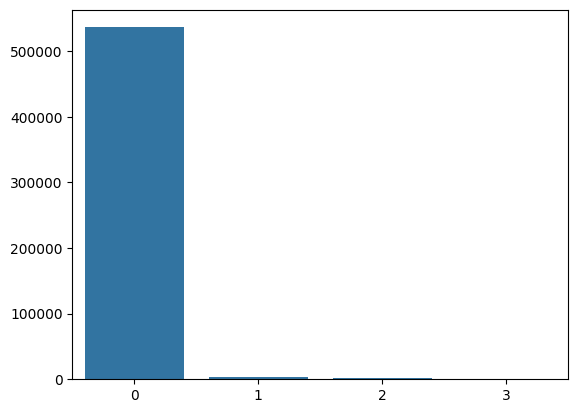

In [39]:
draw_bar(t127_result)

In [40]:
def get_reads_for_inv(data):
    """Get the reads for inversions."""
    plot_data = defaultdict(list)

    for k, vs in data.items():
        for v in vs:
            sv_type = v[0].split(":")[0]
            if sv_type == "INV":
                plot_data[k].extend(v[1].split(","))
    return plot_data

In [41]:
reads_for_inv = get_reads_for_inv(t127_result)

In [42]:
# use comma to split the numbers in string
print(f"{len(reads_for_inv[0])} reads for inversion 0") # noq: E999

2243264 reads for inversion 0


In [43]:
def draw_bar_hue_by_sv_type(data):
    plot_data = defaultdict(list)

    for k,vs in data.items():
        for v in vs:
            plot_data[k].append(v[0].split(":")[0])

    return {k: Counter(v) for k,v in plot_data.items()}

In [44]:
draw_bar_hue_by_sv_type(t127_result)

{0: Counter({'INV': 521950,
          'DEL': 6583,
          'INS': 4240,
          'TRA': 1902,
          'DUP': 1741}),
 2: Counter({'INV': 1552, 'DEL': 169, 'TRA': 94, 'INS': 93, 'DUP': 35}),
 1: Counter({'INV': 3170, 'DEL': 321, 'INS': 263, 'TRA': 142, 'DUP': 32}),
 3: Counter({'TRA': 18, 'DEL': 15, 'INV': 14, 'INS': 13, 'DUP': 8})}

In [45]:
def summary_inv_for_all_threshold():
    """Summarize the inversions for all thresholds."""
    tresholds = [100,127, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
    results   = []
    reads_for_inv = []
    for t in tresholds:
        odata = read_sv_annotation(project_path/f"data/sv/PC3_10_cells_MDA_P2_dirty/chimeric_reads_mapping/updated_SVCF/cutesv.annotated_sv_{t}.tsv")
        results.append(draw_bar_hue_by_sv_type(odata))
        reads_for_inv.append(get_reads_for_inv(odata))

    inv_with_sp0 = [res[0]['INV'] for res in results]
    return inv_with_sp0, reads_for_inv

In [46]:
inv_with_sp0_all_thresholds, reads_for_inv_all_thresholds = summary_inv_for_all_threshold()

In [47]:
inv_with_sp0_all_thresholds

[522077,
 521950,
 521782,
 521724,
 521579,
 521421,
 521243,
 521061,
 520916,
 520766,
 520600,
 520450]

<Axes: >

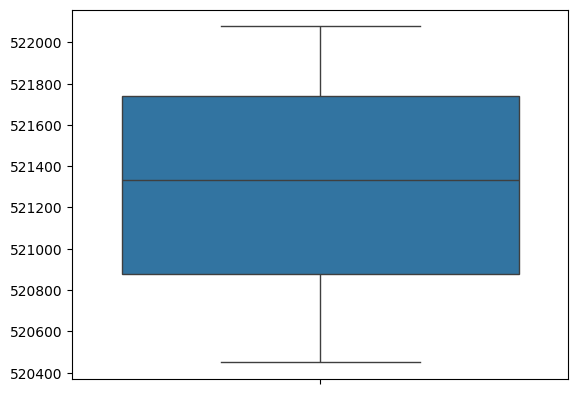

In [48]:
sns.boxplot(inv_with_sp0_all_thresholds)

(500000.0, 530000.0)

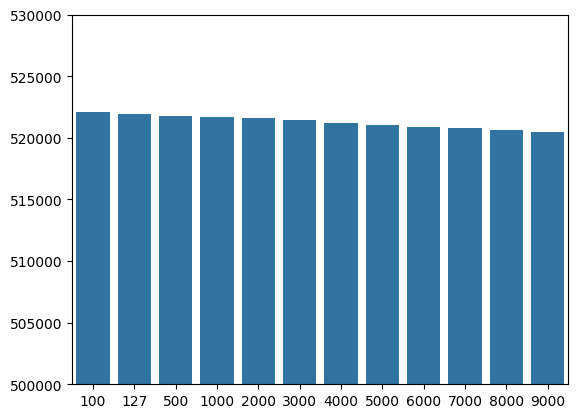

In [49]:
sns.barplot(x=[100, 127, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], y = inv_with_sp0_all_thresholds)
plt.ylim(500000, 530000)

<Axes: >

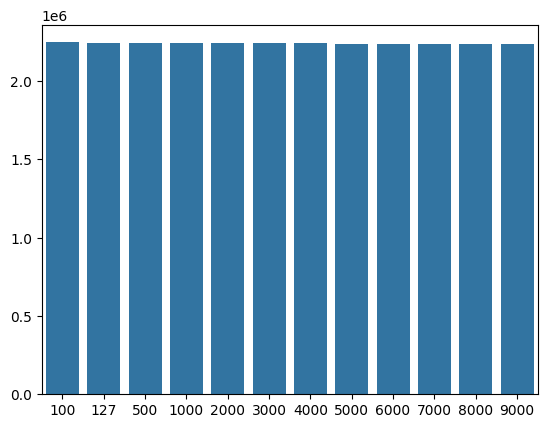

In [50]:
sns.barplot(x=[100,127, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], y = [len(i[0]) for i in reads_for_inv_all_thresholds])

In [21]:
def plot1(data):
    # Create a list of records for the DataFrame
    records = []
    for category, sv_counts in data.items():
        for sv_type, count in sv_counts.items():
            records.append({
                'Category': f'Category {category}',
                'SV Type': sv_type,
                'Count': count
            })

    df = pd.DataFrame(records)

    # Set the style and figure size
    plt.figure(figsize=(12, 6))

    # Create the grouped bar plot
    sns.barplot(data=df, x='Category', y='Count', hue='SV Type', palette='husl')

    # Customize the plot
    plt.title('Distribution of SV Types Across Categories', fontsize=14, pad=15)
    plt.xlabel('Category', fontsize=12)

    # Use log scale for y-axis due to large value differences
    # plt.yscale('log')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)

    # Adjust legend position
    plt.legend(title='SV Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    sns.despine()
    # Adjust layout to prevent label cutoff
    plt.tight_layout()


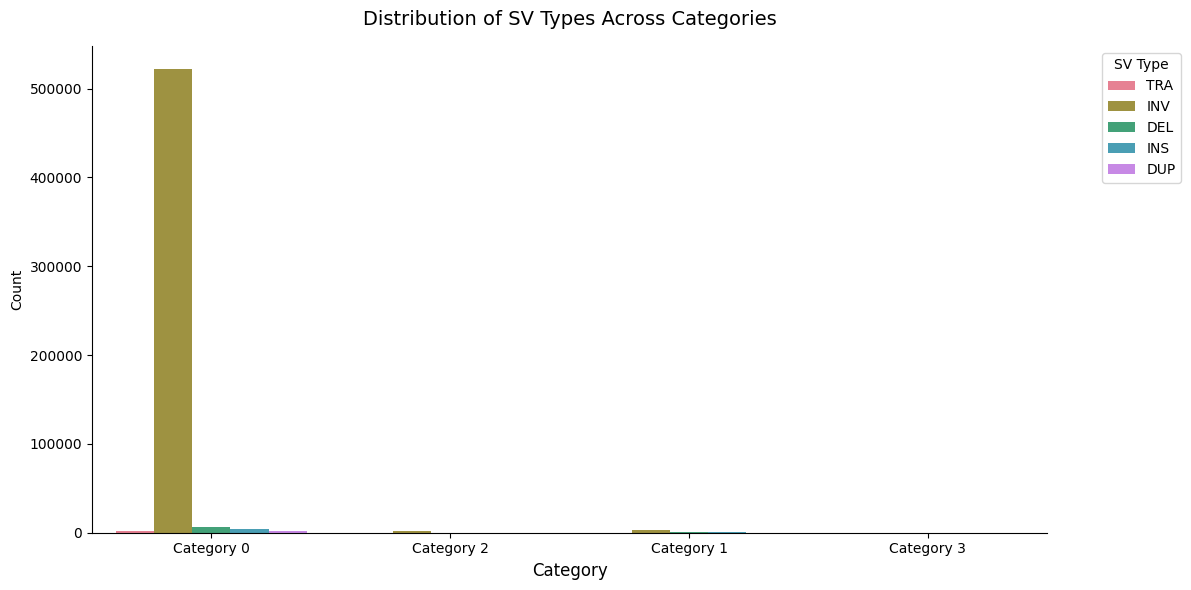

In [22]:
plot1(draw_bar_hue_by_sv_type(t127_result))

In [23]:
def get_read_vs_inv_with_sup(data, sup=0, selected_type="INV"):
    """Get the read vs."""
    result = defaultdict(list)

    for k, vs in data.items():
        if k == sup:
            for  v in vs:
                sv_type = v[0].split(":")[0]
                if sv_type == selected_type:
                    reads = v[1].split(",")
                    for read in reads:
                        result[read] = v[0]
    return result

In [24]:
read_vs_inv_with_sup0 = get_read_vs_inv_with_sup(t127_result)

In [25]:
len(read_vs_inv_with_sup0)

2242678

In [35]:
def write_read_vs_inv_with_sup0(data, file, *, filter_chrom=True):
    with Path.open(file, "w") as f:
        for read, sv in data.items():
            chrom = sv.split(":")[1]
            if filter_chrom:
                if chrom.startswith("chr"):
                    f.write(f"{read}\t{sv}\n")
            else:
                f.write(f"{read}\t{sv}\n")


In [36]:
write_read_vs_inv_with_sup0(read_vs_inv_with_sup0, project_path/"reads_inv_with_sp0_t127.txt")

In [88]:
write_read_vs_inv_with_sup0(read_vs_inv_with_sup0, project_path/"reads_inv_with_sp0_t127_with_contigs.txt", filter_chrom=False)

In [37]:
def get_chrom_distribution_inv_len(data,*, filter_chrom=True):
    from collections import Counter
    chrom_distribution = []
    inv_len = []
    sups_reads_number = []

    for svs in data:
        sv = svs[0]
        reads_count = len(svs[1].split(","))
        svtype, chrom, bps  = sv.split(":")
        bp1, bp2 = bps.split('-')
        if svtype == "INV":
            if filter_chrom:
                if chrom.startswith("chr"):
                    chrom_distribution.append(chrom)
                    inv_len.append(abs(int(bp1) - int(bp2)))
                    sups_reads_number.append(reads_count)

            else:
                chrom_distribution.append(chrom)
                inv_len.append(abs(int(bp1) - int(bp2)))
                sups_reads_number.append(reads_count)

    return Counter(chrom_distribution), inv_len, sups_reads_number

In [38]:
chrom_distribution,sv_len, sups_reads_number = get_chrom_distribution_inv_len(t127_result[0])

In [39]:
chrom_distribution

Counter({'chr7': 52050,
         'chr1': 42814,
         'chr8': 39106,
         'chr10': 35222,
         'chr5': 31873,
         'chr3': 31722,
         'chr6': 29710,
         'chr14': 26268,
         'chr17': 25934,
         'chr11': 25416,
         'chr2': 25060,
         'chr12': 20964,
         'chr4': 20061,
         'chr9': 18194,
         'chr19': 17100,
         'chr20': 14732,
         'chr18': 14045,
         'chr15': 11842,
         'chrX': 10456,
         'chr16': 10402,
         'chr13': 8342,
         'chr21': 6109,
         'chr22': 2811,
         'chrM': 101,
         'chrY': 5})

In [40]:
sum(chrom_distribution.values())

520339

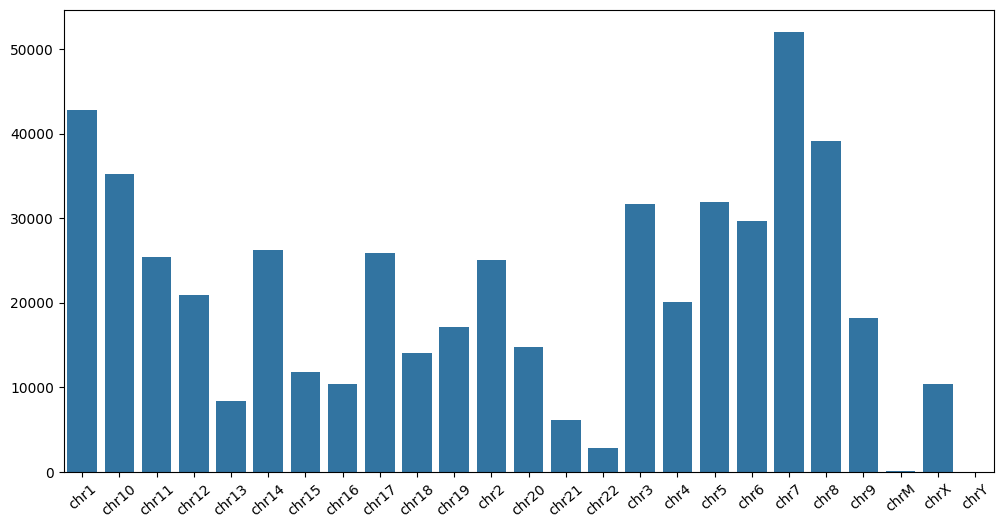

In [41]:
# Set the style and figure size
plt.figure(figsize=(12, 6))
sns.barplot(chrom_distribution)
_ = plt.xticks(rotation=40)

In [42]:
len(sv_len)

520339

<Axes: ylabel='Count'>

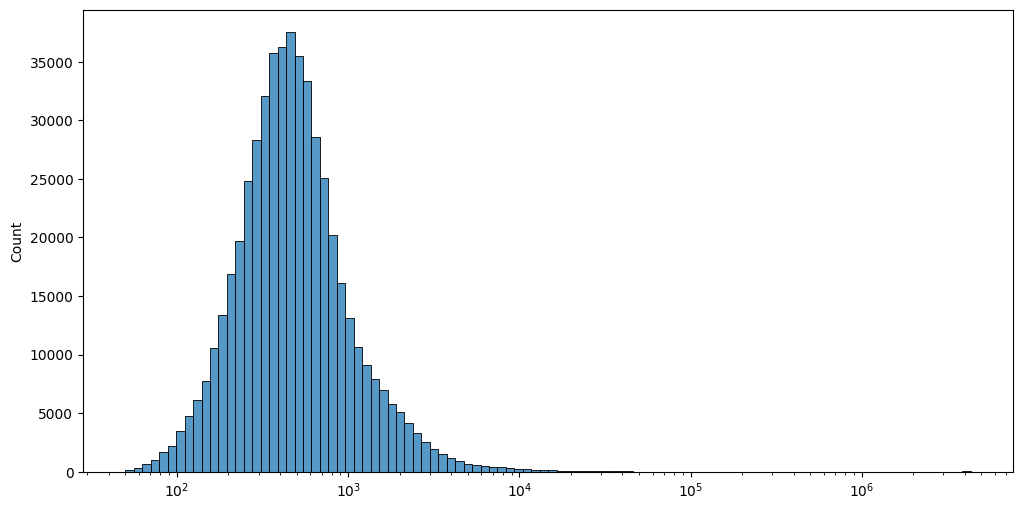

In [43]:
# Set the style and figure size
plt.figure(figsize=(12, 6))
sns.histplot(sv_len, bins=100, log_scale=True)

In [51]:
{k: len(v)  for k,v in t127_result.items()}

{0: 536416, 2: 1943, 1: 3928, 3: 68}

In [52]:
draw_bar_hue_by_sv_type(t127_result)

{0: Counter({'INV': 521950,
          'DEL': 6583,
          'INS': 4240,
          'TRA': 1902,
          'DUP': 1741}),
 2: Counter({'INV': 1552, 'DEL': 169, 'TRA': 94, 'INS': 93, 'DUP': 35}),
 1: Counter({'INV': 3170, 'DEL': 321, 'INS': 263, 'TRA': 142, 'DUP': 32}),
 3: Counter({'TRA': 18, 'DEL': 15, 'INV': 14, 'INS': 13, 'DUP': 8})}

In [53]:
sup2_inv_reads = get_read_vs_inv_with_sup(t127_result, sup=2, selected_type="INV")

In [54]:
len(sup2_inv_reads)

31973

In [55]:
sup2_del_reads = get_read_vs_inv_with_sup(t127_result, sup=2, selected_type="DEL")

In [56]:
len(sup2_del_reads)

2008

In [57]:
def get_read_with_sup(data, sups, selcted_types = ["INV", "DEL", "INS", "DUP", "TRA"]):
    result = defaultdict(dict)
    for sup in sups:
        for st in selcted_types:
            result[sup][st] = get_read_vs_inv_with_sup(data, sup, st)

    return result

In [58]:
sups_with_reads = get_read_with_sup(t127_result, sups=[1,2,3])

In [59]:
sups_with_reads[1]["INV"]

defaultdict(list,
            {'fd5c7ab8-7e35-472a-bc56-773384f8ac56': 'INV:KI270467.1:1765-1987',
             '8953ca2c-b73a-4af1-a313-9af988295177': 'INV:KI270467.1:1765-1987',
             '5ee41791-6d8e-4ee8-b30c-0ee317651c2f': 'INV:KI270467.1:1765-1987',
             'eddfc1e8-139a-4707-8d4b-948456aa5040': 'INV:KI270467.1:1765-1987',
             'fe62407f-2231-4a2c-84c5-ef822f08b5f3': 'INV:KI270467.1:1765-1987',
             'cbb622df-6eb1-45ea-8e74-d38e27bb4036': 'INV:KI270467.1:1765-1987',
             'f8fda795-7fa1-494e-ba85-d802899d9535': 'INV:KI270467.1:1929-2120',
             'f2ec52d4-62c2-4bfc-be45-4b3dde4a9a53': 'INV:KI270467.1:1929-2120',
             '3bd1d0bd-ad01-473c-93ab-ae86d7fe3627': 'INV:KI270467.1:1929-2120',
             '89f46291-4305-46c1-938d-c9dec062498a': 'INV:KI270467.1:1929-2120',
             '94ab21dc-27d0-41ff-b477-a679ef564406': 'INV:KI270467.1:1929-2120',
             '928f9264-2427-4ad4-a3f6-2bca317e99bb': 'INV:KI270467.1:2084-2165',
          

In [75]:
for sup, dt in sups_with_reads.items():
    print(f"\nSup: {sup}")
    total = 0
    for sv, rs in dt.items():
        print(f"Sup: {sup}, SV Type: {sv}, Read Count: {len(rs)}")
        total += len(rs)
    print(f"Total Read Count: {total}")


Sup: 1
Sup: 1, SV Type: INV, Read Count: 65328
Sup: 1, SV Type: DEL, Read Count: 4630
Sup: 1, SV Type: INS, Read Count: 3702
Sup: 1, SV Type: DUP, Read Count: 1104
Sup: 1, SV Type: TRA, Read Count: 1703
Total Read Count: 76467

Sup: 2
Sup: 2, SV Type: INV, Read Count: 31973
Sup: 2, SV Type: DEL, Read Count: 2008
Sup: 2, SV Type: INS, Read Count: 1185
Sup: 2, SV Type: DUP, Read Count: 400
Sup: 2, SV Type: TRA, Read Count: 1432
Total Read Count: 36998

Sup: 3
Sup: 3, SV Type: INV, Read Count: 312
Sup: 3, SV Type: DEL, Read Count: 263
Sup: 3, SV Type: INS, Read Count: 176
Sup: 3, SV Type: DUP, Read Count: 250
Sup: 3, SV Type: TRA, Read Count: 257
Total Read Count: 1258


In [77]:
def save_negativ_reads(data, output):
    """Save DEL, INS, DUP, and TRA of sup 1, all types of sup2 and sup3."""
    result = [] 
    
    for sup in [1, 2, 3]:
        for st in ["DEL", "INS", "DUP", "TRA", "INV"]:
            if sup == 1 and st == "INV":
                continue

            reads = data[sup][st]
            for read, sv in reads.items():
                result.append((read,sv))


    print(f"save {len(result)}")    
    with open(output, 'w') as f:           
        for (read,sv) in result:
            f.write(f"{read}\t{sv}\n")

In [94]:
def save_negativ_reads_without_dup(data, output):
    """Save DEL, INS, DUP, and TRA of sup 1, all types of sup2 and sup3."""
    result = [] 
    unique_reads = set()

    for sup in [1, 2, 3]:
        for st in ["DEL", "INS", "DUP", "TRA", "INV"]:
            if sup == 1 and st == "INV":
                continue

            reads = data[sup][st]
            for read, sv in reads.items():
                if read not in unique_reads:
                    unique_reads.add(read)
                    result.append((read,sv))

    print(f"save {len(result)}")    
    with open(output, 'w') as f:           
        for (read,sv) in result:
            f.write(f"{read}\t{sv}\n")

In [78]:
save_negativ_reads(sups_with_reads, project_path/ "reads_neg_t127_with_contigs.txt")

save 49395


In [95]:
save_negativ_reads_without_dup(sups_with_reads, project_path/ "reads_neg_t127_with_contigs_without_dup.txt")

save 48311


In [76]:
36998 +  1258 + 76467 - 65328

49395

# Select Reads 

In [ ]:
# 2242678 data/train_data/reads_inv_with_sp0_t127_with_contigs.txt
# 49395 data/train_data/reads_neg_t127_with_contigs.txt

In [68]:
def load_reads(path):
    pos_reads = []
    with Path(path).open() as pos_f:
        for line in pos_f:
            pos_reads.append(line.strip().split()[0])
    return pos_reads

In [69]:
pos_reads = load_reads(project_path/"data/train_data/80000/reads_inv_with_sp0_t127_with_contigs.txt")

In [71]:
len(set(pos_reads))

2242678

In [98]:
neg_reads =  load_reads(project_path/"data/train_data/80000/reads_neg_t127_with_contigs_without_dup.txt")

In [100]:
len(neg_reads)

48311

In [101]:
len(set(neg_reads))

48311

In [83]:
import logging
import random

from rich.logging import RichHandler

FORMAT = "%(message)s"
logging.basicConfig(
    level="INFO", format=FORMAT, datefmt="[%X]", handlers=[RichHandler()]
)

log = logging.getLogger("rich")

def select_reads(pos_path, neg_path, total_reads, pos_ratio=0.5, training_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """Select positive and negative reads based on their ratio and split into train/val/test sets.
    
    Args:
        pos_path: Path to positive reads file
        neg_path: Path to negative reads file
        total_reads: Total number of reads to select
        pos_ratio: Ratio of positive samples (default: 0.5 for 1:1 ratio)
        training_ratio: Ratio for training set (default: 0.7)
        val_ratio: Ratio for validation set (default: 0.2)
        test_ratio: Ratio for test set (default: 0.1)
   
    Returns:
        tuple: (train_data, val_data, test_data)
    """
    # Input validation
    if abs(training_ratio + val_ratio + test_ratio - 1.0) > 1e-10:
        raise ValueError("Split ratios must sum to 1.0")

    # Load positive reads
    pos_reads = load_reads(pos_path) 
    log.info(f"Loaded {len(pos_reads)} positive reads from {pos_path}")

    # Load negative reads
    neg_reads = load_reads(neg_path)
    log.info(f"Loaded {len(neg_reads)} negative reads from {neg_path}")

    # Calculate counts for positive and negative samples
    pos_count = int(total_reads * pos_ratio)
    neg_count = total_reads - pos_count

    # Verify we have enough samples
    if len(pos_reads) < pos_count:
        raise ValueError(f"Not enough positive reads. Required: {pos_count}, Available: {len(pos_reads)}")

    if len(neg_reads) < neg_count:
        raise ValueError(f"Not enough negative reads. Required: {neg_count}, Available: {len(neg_reads)}")

    # Randomly sample positive and negative reads
    selected_pos_reads = random.sample(pos_reads, pos_count)
    selected_neg_reads = random.sample(neg_reads, neg_count)

    # Calculate split sizes
    train_size = int(total_reads * training_ratio)
    val_size = int(total_reads * val_ratio)
    test_size = total_reads - train_size - val_size  # Use remainder to avoid rounding errors

    # Calculate positive and negative samples for each split
    train_pos = int(train_size * pos_ratio)
    val_pos = int(val_size * pos_ratio)
    test_pos = pos_count - train_pos - val_pos

    train_neg = train_size - train_pos
    val_neg = val_size - val_pos
    test_neg = neg_count - train_neg - val_neg

    # Create splits while maintaining pos/neg ratio
    train_data = selected_pos_reads[:train_pos] + selected_neg_reads[:train_neg]
    val_data = selected_pos_reads[train_pos:train_pos+val_pos] + \
               selected_neg_reads[train_neg:train_neg+val_neg]
    test_data = selected_pos_reads[train_pos+val_pos:] + \
                selected_neg_reads[train_neg+val_neg:]

    # Shuffle each split
    random.shuffle(train_data)
    random.shuffle(val_data)
    random.shuffle(test_data)

    # Log split sizes
    log.info(f"Train set: {len(train_data)} samples ({train_pos} positive, {train_neg} negative)")
    log.info(f"Validation set: {len(val_data)} samples ({val_pos} positive, {val_neg} negative)")
    log.info(f"Test set: {len(test_data)} samples ({test_pos} positive, {test_neg} negative)")

    return train_data, val_data, test_data

In [105]:
TOTAL_READS=80000

In [102]:
selected_reads = select_reads(project_path/f"data/train_data/{TOTAL_READS}/reads_inv_with_sp0_t127_with_contigs.txt",
project_path/f"data/train_data/{TOTAL_READS}/reads_neg_t127_with_contigs_without_dup.txt",
total_reads=TOTAL_READS,
pos_ratio=0.5,
)

[20:20:18] INFO     Loaded 2242678 positive reads from                                              ]8;id=588614;file:///tmp/ipykernel_16526/648160117.py\648160117.py]8;;\:]8;id=228440;file:///tmp/ipykernel_16526/648160117.py#34\34]8;;\
                    /projects/b1171/ylk4626/project/Chimera/data/train_data/80000/reads_inv_with_sp                
                    0_t127_with_contigs.txt                                                                        

           INFO     Loaded 48311 negative reads from                                                ]8;id=621814;file:///tmp/ipykernel_16526/648160117.py\648160117.py]8;;\:]8;id=872159;file:///tmp/ipykernel_16526/648160117.py#38\38]8;;\
                    /projects/b1171/ylk4626/project/Chimera/data/train_data/80000/reads_neg_t127_wi                
                    th_contigs_without_dup.txt                                                                     

           INFO     Train set: 56000 samples (28000 positive, 28000 negative)                       ]8;id=508932;file:///tmp/ipykernel_16526/648160117.py\648160117.py]8;;\:]8;id=431010;file:///tmp/ipykernel_16526/648160117.py#82\82]8;;\

           INFO     Validation set: 16000 samples (8000 positive, 8000 negative)                    ]8;id=207683;file:///tmp/ipykernel_16526/648160117.py\648160117.py]8;;\:]8;id=149139;file:///tmp/ipykernel_16526/648160117.py#83\83]8;;\

           INFO     Test set: 8000 samples (4000 positive, 4000 negative)                           ]8;id=122481;file:///tmp/ipykernel_16526/648160117.py\648160117.py]8;;\:]8;id=20735;file:///tmp/ipykernel_16526/648160117.py#84\84]8;;\

In [103]:
def save_selected_reads(selected_reads, output_prefix):
    """Save selected reads into separate files for each split.

    Args:
        selected_reads: Tuple of (train_data, val_data, test_data)
        output_prefix: Path to output files
    """
    if isinstance(output_prefix, Path):
        output_prefix = output_prefix.as_posix()

    train_data, val_data, test_data = selected_reads
    with Path(output_prefix+ "_train.txt").open("w") as train_f,  Path(output_prefix + "_val.txt").open("w") as val_f, Path(output_prefix + "_test.txt").open('w') as test_f:
        for read in train_data:
            train_f.write(f"{read}\n")
        for read in val_data:
            val_f.write(f"{read}\n")
        for read in test_data:
            test_f.write(f"{read}\n")

In [106]:
save_selected_reads(selected_reads, project_path/f"data/train_data/{TOTAL_READS}/reads_inv_with_sp0_t127_with_contigs")